In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from logger import logger
import os
import cv2
%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)

In [2]:
train = np.load('./data/train/train_dataset.npy')
labels = np.load('./data/train/labels.npy')

In [3]:
# Scaling data to standard mean and variance.
scaler0 = StandardScaler()
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()

train[:,:,:,0] = scaler0.fit_transform(train[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,1] = scaler1.fit_transform(train[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,2] = scaler2.fit_transform(train[:,:,:,2].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,3] = scaler3.fit_transform(train[:,:,:,3].reshape(-1,1)).reshape(-1,75,75)

scalers = (scaler0, scaler1, scaler2, scaler3)
print train.shape

(1604, 75, 75, 4)


In [4]:
def prepare_test_data() :
    global scaler0, scaler1, scaler2, scaler3
    test_dataset = np.load('./data/test/test_dataset.npy')
    test_ids = np.load('./data/test/ids.npy')

    test_dataset[:,:,:,0] = scaler0.transform(test_dataset[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,1] = scaler1.transform(test_dataset[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,2] = scaler2.transform(test_dataset[:,:,:,2].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,3] = scaler3.transform(test_dataset[:,:,:,3].reshape(-1,1)).reshape(-1,75,75)
    
    #test_dataset = test_dataset[:,:,:,2:4]
    print test_dataset.shape
    return test_dataset, test_ids

In [5]:
# DATA augmentation. from kerenel, https://www.kaggle.com/vincento/keras-starter-4l-0-1936-lb-icebergchallenge/code
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        d=imgs[i,:,:,3]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        dv=cv2.flip(d,1)
        dh=cv2.flip(d,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv, dv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch, dh)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

train = get_more_images(train)
labels = np.concatenate((labels,labels,labels))
print train.shape
print labels.shape

(4812, 75, 75, 4)
(4812, 1)


In [6]:
# getting validation set
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train, labels, test_size=.1)


print train_dataset.shape, train_labels.shape
print valid_dataset.shape, valid_labels.shape

del train, labels

(4330, 75, 75, 4) (4330, 1)
(482, 75, 75, 4) (482, 1)


------------------------

 ** An iceberg


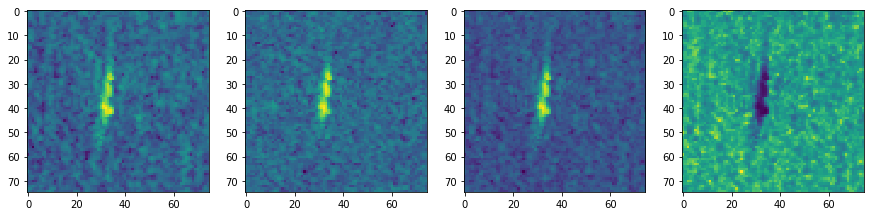

In [7]:
plt.rcParams["figure.figsize"] = [15,15]
index = np.random.randint(0, train_dataset.shape[0])
f, axarr = plt.subplots(1,4)
_ = axarr[0].imshow(train_dataset[index,:,:,0])
_ = axarr[1].imshow(train_dataset[index,:,:,1])
_ = axarr[2].imshow(train_dataset[index,:,:,2])
_ = axarr[3].imshow(train_dataset[index,:,:,3])

print " ** A ship" if train_labels[index,0] == 1 else " ** An iceberg"

In [8]:
#train_dataset = train_dataset[:,:,:,2:4]
#valid_dataset = valid_dataset[:,:,:,2:4]


In [9]:
def extract_batch(i):
    
    start_idx = (i * batch_size) % (train_dataset.shape[0] - batch_size )
    end_idx = start_idx + batch_size
    batch_data = train_dataset[ start_idx : end_idx ]
    batch_labels = train_labels[ start_idx : end_idx ]
    
    return batch_data, batch_labels.astype(np.float32)

In [10]:
def create_placeholders(n_H, n_W, n_C, n_y, name1='X', name2='Y'):
    '''
    Create X and Y placeholder, ready for each minibatch
    input : 
        n_H : height of input image
        n_W : width of input image
        n_C : number of channels per image
        n_y  : number of classes
    '''
    X = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name1)
    Y = tf.placeholder(tf.float32, [None, n_y], name2)
    
    return X,Y

In [11]:
def convolution_layer(input_, training,
                      filters, kernel_size, conv_strides, 
                      pool_size, pool_strides,
                      dropout_rate) :
    
    with tf.variable_scope('conv_layer'):
                
        Z = tf.layers.conv2d(input_, filters, kernel_size, conv_strides, 'SAME', activation=tf.nn.relu)
        
        #Z = tf.layers.batch_normalization(Z)
        
        #Z = tf.layers.max_pooling2d(Z, pool_size, pool_strides, 'SAME')
        
        Z = tf.layers.dropout(Z, dropout_rate, training=training)
   
    return Z

In [12]:
def compute_loss(Z, Y):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z, labels=Y))
    return loss

In [13]:
def optimize(loss, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(loss, global_step=global_step) 
    return optimizer

In [14]:
def get_summary(loss, tf_valid_loss):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('valid_loss', tf_valid_loss)
    return tf.summary.merge_all()

In [15]:
def predict_test(sub_id='nan'):
    data, ids = prepare_test_data()
    #f = open('./data/submission217.csv', 'wb')
    #f.write('id,is_iceberg\n')
    print "\npredicting test dataset"
    step = 200
    n_steps = data.shape[0] / step
    all_preds = None
    for sind in range(0,data.shape[0], step) :
        print "step", sind/step, 'of', n_steps, '....'
        #-----------------------------------
        eind = sind + step
        if eind > data.shape[0] :
            eind = data.shape[0]
         #--------------------------------------
        preds = sess.run(tf_test_pred, feed_dict={X_test : data[sind:eind]})
        try :
            all_preds = np.concatenate((all_preds,preds),axis=0)
        except :
            all_preds = preds
    #----------------------------------------------------------------------
    sub_df = pd.DataFrame({'id':ids, 'is_iceberg':all_preds.reshape((-1))})
    sub_df.to_csv('./data/submissions/submission-{}'.format(sub_id), index=False)
    #    for e1, e2 in zip(test_ids[sind:eind], test_pred):
    #        f.write('{},{}\n'.format(e1,e2[0]))
    #f.close()
    print "finished predicting\n"
    return

In [16]:
def inference(X, training=True):
    ts = ''
    with tf.variable_scope('block_1'):
        ts += 'block 1 :\n'
        L = tf.layers.conv2d(X, 64, 5, activation=tf.nn.relu)
        ts += 'conv2d : c=64, f=3, shape={}\n'.format(L.shape)
        L = tf.layers.batch_normalization(L)
        L = tf.layers.conv2d(L, 64, 5, activation=tf.nn.relu)
        ts += 'conv2d : c=64, f=3, shape={}\n'.format(L.shape)
        L = tf.layers.batch_normalization(L)
        L = tf.layers.max_pooling2d(L, 2, 2)
        L = tf.layers.dropout(L)
        ts += 'maxpooling : f=2, s=2, shape={}\n'.format(L.shape)
    with tf.variable_scope('block_2'):
        ts += '======================================\n'
        ts += 'block2 : \n'
        L = tf.layers.conv2d(L, 128, 5, activation=tf.nn.relu)
        ts += 'conv2d : c=128, f=3, shape={}\n'.format(L.shape)
        L = tf.layers.batch_normalization(L)
        L = tf.layers.conv2d(L, 128, 5, activation=tf.nn.relu)
        ts += 'conv2d : c=128, f=3, shape={}\n'.format(L.shape)
        L = tf.layers.batch_normalization(L)
        L = tf.layers.max_pooling2d(L, 2, 2)
        ts += 'maxpooling : f=2, s=2, shape={}\n'.format(L.shape)
        L = tf.layers.dropout(L)
    #with tf.variable_scope('block_3'):
        #ts += '======================================\n'
        #ts += 'block3 : \n'
        #L = tf.layers.conv2d(L, 256, 3, activation=tf.nn.relu)
        #ts += 'conv2d : c=256, f=3, shape={}\n'.format(L.shape)
        #L = tf.layers.conv2d(L, 256, 3, activation=tf.nn.relu)
        #ts += 'conv2d : c=256, f=3, shape={}\n'.format(L.shape)
        #L = tf.layers.conv2d(L, 256, 3, activation=tf.nn.relu)
        #ts += 'conv2d : c=256, f=3, shape={}\n'.format(L.shape)
        #L = tf.layers.max_pooling2d(L, 2, 2)
        #ts += 'maxpooling : f=2, s=2, shape={}\n'.format(L.shape)
    with tf.variable_scope('fully_connected'):
        ts += '======================================\n'
        ts += 'Fully connected : \n'
        L = tf.layers.flatten(L)
        ts += 'Flatten : shape={}\n'.format(L.shape)
        L = tf.contrib.layers.fully_connected(L, 8, tf.nn.relu)
        L = tf.layers.batch_normalization(L)
        L = tf.layers.dropout(L)
        ts += 'fully connected : n = 1024, shape={}\n'.format(L.shape)
        #L = tf.contrib.layers.fully_connected(L, 512, tf.nn.relu)
        #ts += 'fully connected : n = 512, shape={}\n'.format(L.shape)
        L = tf.contrib.layers.fully_connected(L, 1, None)
        ts += 'fully connected : n = 1, shape={}\n'.format(L.shape)
    if training: print ts
    return L

In [17]:
# Defining Model graph :
learning_rate = 0.001
n_H, n_W, n_C = train_dataset.shape[1:]
n_y = train_labels.shape[1]

graph = tf.Graph()
with graph.as_default():
    
    with tf.variable_scope('input_data'):
        X, Y = create_placeholders(n_H, n_W, n_C, n_y)
        X_valid, Y_valid = create_placeholders(n_H, n_W, n_C, n_y, 'X_valid', 'Y_valid')
        X_test = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name='X_test')
        
    with tf.variable_scope('forward_propogation', reuse=tf.AUTO_REUSE):
        Z = inference(X)
        Z_valid = inference(X_valid, training=False)
        Z_test = inference(X_test, training=False)
    
    with tf.variable_scope('loss'):
        tf_loss = compute_loss(Z, Y)
        tf_loss_valid = compute_loss(Z_valid, Y_valid)
    
    with tf.variable_scope('training'):
        global_step = tf.Variable(0, name='global_step',trainable=False)
        optimizer = optimize(tf_loss, global_step)
    
    with tf.variable_scope('summary'):
        #summary_writer = tf.summary.FileWriter('./tmp/logs/', graph)
        summary = get_summary(tf_loss, tf_loss_valid)
    
    with tf.variable_scope('model_saver'):
        saver = tf.train.Saver()
    
    with tf.variable_scope('test_predictions'):
        tf_test_pred = tf.sigmoid(Z_test)
    

block 1 :
conv2d : c=64, f=3, shape=(?, 71, 71, 64)
conv2d : c=64, f=3, shape=(?, 67, 67, 64)
maxpooling : f=2, s=2, shape=(?, 33, 33, 64)
block2 : 
conv2d : c=128, f=3, shape=(?, 29, 29, 128)
conv2d : c=128, f=3, shape=(?, 25, 25, 128)
maxpooling : f=2, s=2, shape=(?, 12, 12, 128)
Fully connected : 
Flatten : shape=(?, 18432)
fully connected : n = 1024, shape=(?, 8)
fully connected : n = 1, shape=(?, 1)



In [ ]:
# defining Session to run all the above.
# displaying paramters
avg_loss = 0
avg_valid_loss = 0
display_step = 10
#----------------------------
saving_step = 50
batch_size = 32
epoches = 4000
# early stopping parameters
best_loss = 999
ESRounds = 500
rounds = 0
#-------------------------
# logging
logging = True
log = None
#----------------------------
# intialize logfile
def init_log():
    global log
    file_index = sorted([int(f.split('.')[0]) for f in os.listdir('./tmp/onrun-log/')])[-1] + 1
    log = logger('{}.log'.format(file_index), log_dir='./tmp/onrun-log/')
    log.add("epoches = {}, batch_size = {}, ESRounds = {}, training shape = {}, validation shape = {},"
            " Run on {}\n------"\
            .format(epoches,batch_size,ESRounds,train_dataset.shape,valid_dataset.shape,np.datetime64('now')))
    print "Log file is ready."
#------------------------------
def trainer(sess):
    global avg_loss, avg_valid_loss, display_step, batch_size, epoches, best_loss, ESRounds, rounds
    
    tf.global_variables_initializer().run()

    summary_writer = tf.summary.FileWriter('./tmp/logs/', sess.graph)
    
    for i in range(epoches):
        
        batch_data, batch_labels = extract_batch(i)
        feed_dict = { X : batch_data, Y : batch_labels}#, X_valid : valid_dataset, Y_valid : valid_labels }
        _, l = sess.run([optimizer, tf_loss], feed_dict=feed_dict)
        avg_loss += l
        #avg_valid_loss += valid_loss
        
        # Print loss after each N display steps, also add summary to file.
        if i % display_step == 0 :
            avg_loss /= display_step
            #avg_valid_loss /= display_step
            #feed_dict[X_valid] = valid_dataset
            #feed_dict[Y_valid] = valid_labels
            #summary_str = sess.run(summary, feed_dict=feed_dict)
            #_ = summary_writer.add_summary(summary_str, sess.run(global_step))
            avg_valid_loss = sess.run(tf_loss_valid, {X_valid:valid_dataset, Y_valid:valid_labels})
            print "Finished {} steps [{:.3g}%],\t loss : {},\t valid loss : {} "\
                               .format(i,1.*i*batch_size/train_dataset.shape[0],avg_loss,avg_valid_loss)
            if logging : log.add("Finished {} steps [{:.3g}%],\t loss : {},\t valid loss : {} "\
                               .format(i,1.*i*batch_size/train_dataset.shape[0],avg_loss,avg_valid_loss))
            avg_loss = 0
            #avg_valid_loss = 0
            valid_loss = avg_valid_loss
        # ADD early stopping Step.
        if valid_loss < best_loss :
            print "New best loss : {}, on round : {} and step : {}".format(valid_loss,rounds,i)
            log.add("New best loss : {}, on round : {} and step : {}".format(valid_loss,rounds,i))
            best_loss = valid_loss
            rounds = 0
            _ = saver.save(sess, './tmp/model_checkpoints/model-ckpt-best')
        else :
            if rounds == ESRounds :
                print "reached the specified early stopping rounds [{}]\n.Stopping Model.".format(ESRounds)
                if logging : log.add("reached the specified early stopping rounds [{}]\n.Stopping Model."\
                                     .format(ESRounds))
                summary_writer.close()
                break
            rounds += 1
        
        #if i % saving_step == 0 and i > 0:
        #    print "Saving model"
        #    _ = saver.save(sess, './tmp/model_checkpoints/model-checkpoint', global_step=global_step)
    # predict test_data
    #predict_test()
    summary_writer.close()

    

In [ ]:
train = True
#----------------------------------
with tf.Session(graph=graph) as sess :
    if train :
        if logging : init_log()
        trainer(sess)
    else : # load best ckpt and predict test data
        _ = saver.restore(sess, './tmp/model_checkpoints/model-ckpt-best')
        valid_loss = sess.run(tf_loss_valid, {X_valid:valid_dataset, Y_valid:valid_labels})
        print valid_loss
        predict_test()

Log file is ready.
Finished 0 steps [0%],	 loss : 0.067468893528,	 valid loss : 3.45542812347 
New best loss : 3.45542812347, on round : 0 and step : 0
Finished 10 steps [0.0739%],	 loss : 1.03261901736,	 valid loss : 0.691839516163 
New best loss : 0.691839516163, on round : 9 and step : 10
Finished 20 steps [0.148%],	 loss : 0.673747485876,	 valid loss : 0.69245827198 
Finished 30 steps [0.222%],	 loss : 0.676819723845,	 valid loss : 0.695423066616 
Finished 40 steps [0.296%],	 loss : 0.671017062664,	 valid loss : 0.662434518337 
New best loss : 0.662434518337, on round : 29 and step : 40
Finished 50 steps [0.37%],	 loss : 0.638060081005,	 valid loss : 0.643464624882 
New best loss : 0.643464624882, on round : 9 and step : 50
Finished 60 steps [0.443%],	 loss : 0.652924984694,	 valid loss : 0.650653660297 
Finished 70 steps [0.517%],	 loss : 0.622969198227,	 valid loss : 0.624059319496 
New best loss : 0.624059319496, on round : 19 and step : 70
Finished 80 steps [0.591%],	 loss : 0.